In [1]:
# script to compare SSA/equivalent diameter from CT and integrating spheres
from read_CT_txt_files import read_CT_txt_files
import matplotlib.pyplot as plt

from snowexsql.db import get_db
from snowexsql.data import LayerData, PointData
from snowexsql.conversions import points_to_geopandas, query_to_geopandas

# read micro CT for 2N13
site='2N13'
data_dir='../data/microCT/' + site + '/'
[SSA_CT,height_min,height_max]=read_CT_txt_files(data_dir)

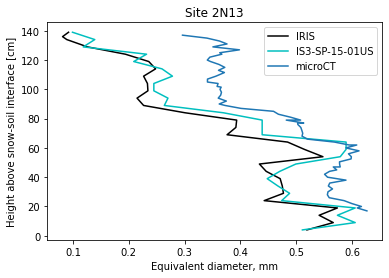

In [2]:
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine_is, session_is = get_db(db_name)

q_is = session_is.query(LayerData).filter(LayerData.type == 'specific_surface_area').filter(LayerData.site_id.contains(site) )
df_is = query_to_geopandas(q_is, engine_is)
instruments_site = df_is['instrument'].unique()

fig,ax = plt.subplots()

# Establish plot colors unique to the instrument
c = ['k', 'm', 'c']

instruments=['IRIS', 'IS3-SP-11-01F', 'IS3-SP-15-01US']

colors = {inst:c[i] for i,inst in enumerate(instruments)}

# plot all instruments at this site
for instr in instruments_site:

    # Grab our profile by site and instrument
    #ind = df['site_id'] == site 
    ind2 = df_is['instrument'] == instr
#    profile = df.loc[ind & ind2].copy()
    profile = df_is.loc[ind2].copy()    

    # Don't plot it unless there is data
    if len(profile.index) > 0:

        # Sort by depth so samples that are take out of order won't mess up the plot
        profile = profile.sort_values(by='depth')

        # Layer profiles are always stored as strings. 
        profile['value'] = 6/917/profile['value'].astype(float)*1000

        # Plot our profile
        ax.plot(profile['value'], profile['depth'], colors[instr], label=instr)


ax.plot(6/917/SSA_CT*1000,height_min,label='microCT')        #CT data
ax.set_xlabel('Equivalent diameter, mm')
ax.set_ylabel('Height above snow-soil interface [cm]')
ax.legend()

ax.set_title(f'Site {site.upper()}')        
plt.show()

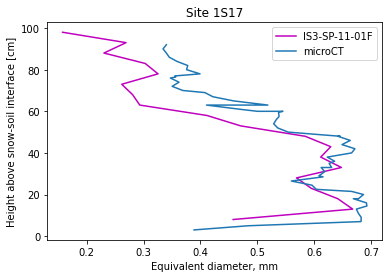

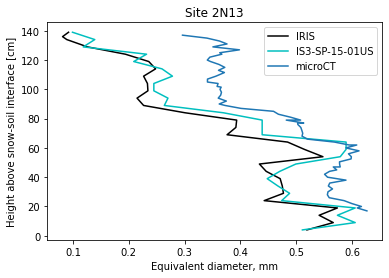

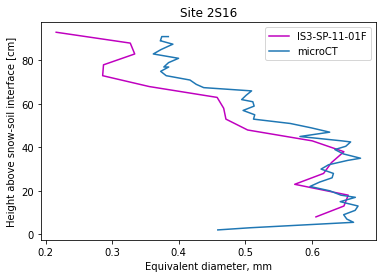

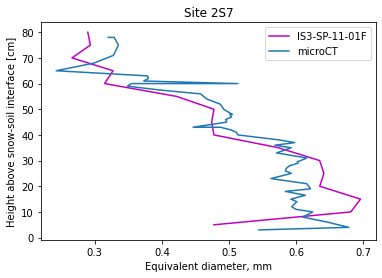

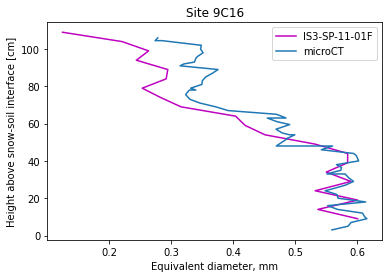

In [6]:
sites=['1S17','2N13','2S16','2S7','9C16']
for site in sites:
    data_dir='../data/microCT/' + site + '/'
    [SSA_CT,height_min,height_max]=read_CT_txt_files(data_dir)
    
    q_is = session_is.query(LayerData).filter(LayerData.type == 'specific_surface_area').filter(LayerData.site_id.contains(site) )
    df_is = query_to_geopandas(q_is, engine_is)
    instruments_site = df_is['instrument'].unique()

    fig,ax = plt.subplots()

    # Establish plot colors unique to the instrument
    c = ['k', 'm', 'c']

    instruments=['IRIS', 'IS3-SP-11-01F', 'IS3-SP-15-01US']

    colors = {inst:c[i] for i,inst in enumerate(instruments)}

    # plot all instruments at this site
    for instr in instruments_site:

        # Grab our profile by site and instrument
        #ind = df['site_id'] == site 
        ind2 = df_is['instrument'] == instr
    #    profile = df.loc[ind & ind2].copy()
        profile = df_is.loc[ind2].copy()    

        # Don't plot it unless there is data
        if len(profile.index) > 0:

            # Sort by depth so samples that are take out of order won't mess up the plot
            profile = profile.sort_values(by='depth')

            # Layer profiles are always stored as strings. 
            profile['value'] = 6/917/profile['value'].astype(float)*1000

            # Plot our profile
            ax.plot(profile['value'], profile['depth'], colors[instr], label=instr)


    ax.plot(6/917/SSA_CT*1000,height_min,label='microCT')        #CT data
    ax.set_xlabel('Equivalent diameter, mm')
    ax.set_ylabel('Height above snow-soil interface [cm]')
    ax.legend()

    ax.set_title(f'Site {site.upper()}')        
    plt.show()
    